In [1]:
train= read.csv('train.csv')
test= read.csv('test.csv')

In [3]:
install.packages("RSNNS")


The downloaded binary packages are in
	/var/folders/qk/0vhw5p4n2610vyrs2zqjmj2h0000gn/T//RtmpQOuu8A/downloaded_packages


In [6]:
install.packages("Metrics")


The downloaded binary packages are in
	/var/folders/qk/0vhw5p4n2610vyrs2zqjmj2h0000gn/T//RtmpQOuu8A/downloaded_packages


In [7]:
library("RSNNS")        # for rbf
library("e1071")        # for tune
library("Metrics")        # for mse

In [8]:
#--------normalization-------------
target_max<-max(train$target)
target_min<-min(train$target)

In [9]:
de_normalization<-function(data,train_max,train_min){
  return(as.integer(data*(train_max-train_min)+train_min))
}

In [10]:
# RBF model
# 1 choose input variables
input1 <-c("temp","atemp","hum", "windspeed" ,"cnt_normal","week_moving_avg_normal",
           "season_1","season_2","season_3","season_4",
           "mnth_1","mnth_2","mnth_3","mnth_4","mnth_5","mnth_6","mnth_7","mnth_8","mnth_9","mnth_10","mnth_11","mnth_12",
           "holiday_1","holiday_2",
           "weekday_1","weekday_2","weekday_3","weekday_4","weekday_5","weekday_6","weekday_7",
           "workingday_1","workingday_2",
           "weathersit_1","weathersit_2","weathersit_3"
)


Parameter tuning of ‘rbf’:

- sampling method: 10-fold cross validation 

- best parameters:
 Var1
   19

- best performance: 0.03530584 

- Detailed performance results:
   Var1      error  dispersion
1     5 0.03548609 0.008763164
2     6 0.03550019 0.008697136
3     7 0.03549503 0.008803411
4     8 0.03533198 0.008609508
5     9 0.03543589 0.008641203
6    10 0.03538322 0.008673194
7    11 0.03555589 0.008741059
8    12 0.03544064 0.008657005
9    13 0.03537805 0.008645710
10   14 0.03555083 0.008702168
11   15 0.03559177 0.008757871
12   16 0.03534837 0.008680443
13   17 0.03537259 0.008589925
14   18 0.03553895 0.008857861
15   19 0.03530584 0.008629847
16   20 0.03543380 0.008590441
17   21 0.03544000 0.008618824
18   22 0.03542846 0.008776042
19   23 0.03540447 0.008562029
20   24 0.03549429 0.008679687
21   25 0.03546544 0.008696163
22   26 0.03534422 0.008561741
23   27 0.03549719 0.008681562
24   28 0.03550641 0.008677442
25   29 0.03540089 0.008625751
26   30 0.03551358 0.0

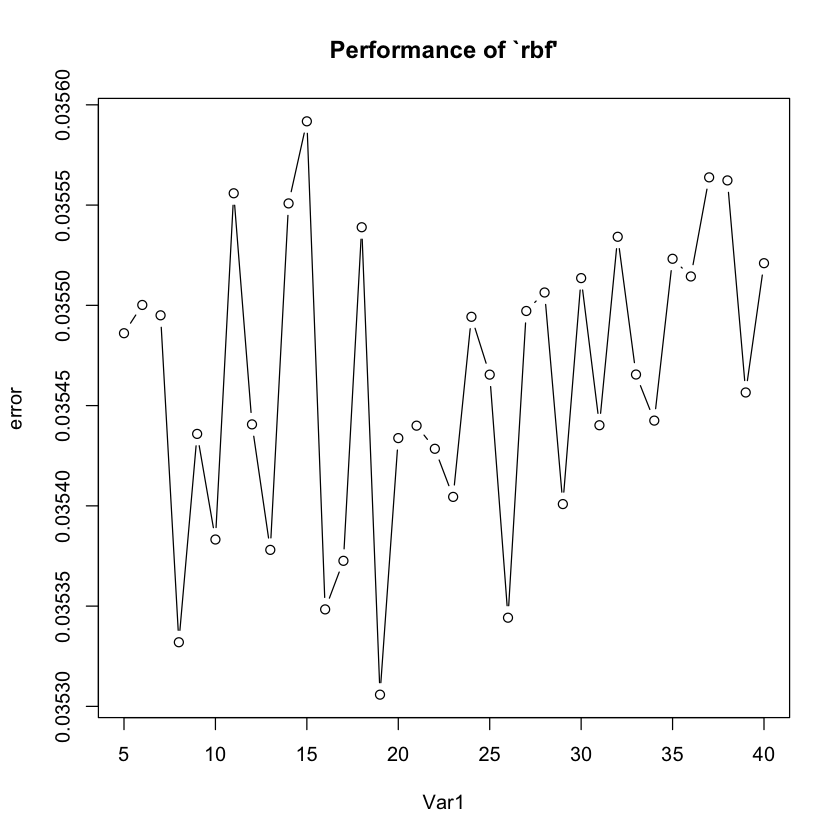

In [11]:
# 2 tune parameter 
# the number of nodes in second layer
obj <- tune(rbf, train.x = as.matrix(train[,input1]), train.y = as.matrix(train$target_normal),
            validation.x = NULL, validation.y = NULL, 
            ranges = (size = c(5:40)))  # set the number range from 5 to 40 
summary(obj)
plot(obj)

In [12]:
# 3 run rbf model with the best parameter
rbf1 <- rbf(as.matrix(train[,input1]), as.matrix(train$target_normal),
            size = 28,
            maxit = 4000,
            initFuncParams = c(0, 1, 0, 0.01, 0.01),
            learnFuncParams=c(1e-8, 0, 1e-8, 0.1, 0.8), 
            linOut=TRUE)

In [13]:
# 4 get predicted target and calculate profit and mse
rbf1_prediction <- de_normalization(predict(rbf1, test[,input1]),target_max,target_min)
rbf1_profit <- sum(pmin(rbf1_prediction,test$target)*3 - rbf1_prediction*2)   # 1495860
mse = mse(rbf1_prediction, test$target)              # 2368631


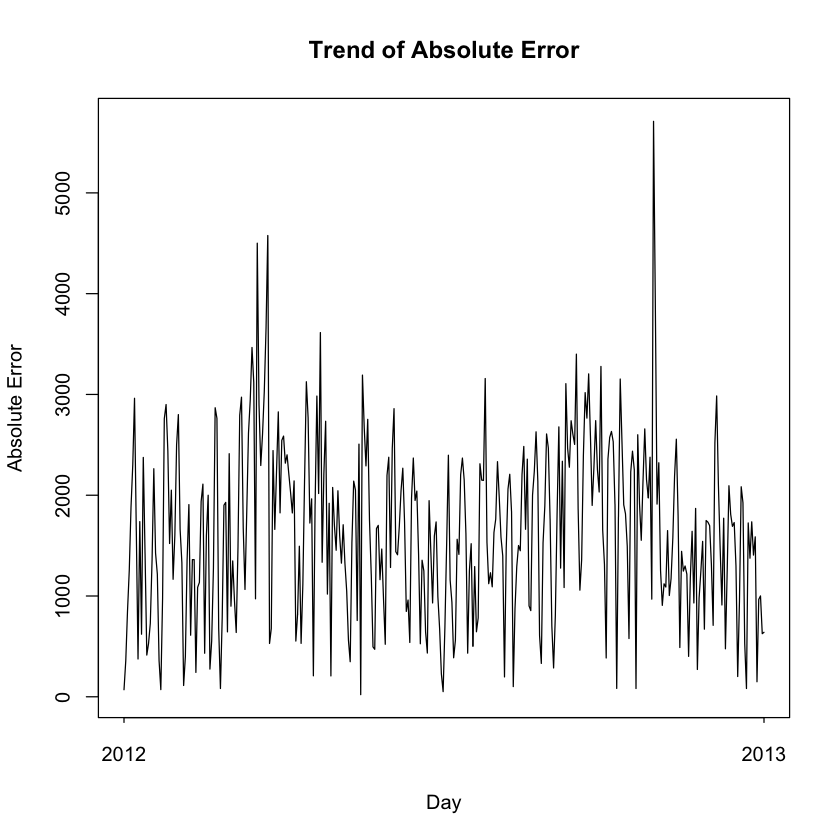

In [14]:
# 5 draw absolute error over time
abs_error_function <- function(predicted_data, observed_data){
  abs_error <- abs(predicted_data - observed_data)
  x =ts(abs_error,start=2012,frequency=365)       #build time series, frequency=365
  plot(x,ylab = 'Absolute Error', xlab = 'Day', main = 'Trend of Absolute Error', xaxt="n")
  axis(side=1, c(2012, 2013), tcl=-0.2, ann = F, labels=TRUE, mgp = c(2, 1, 0))
}
abs_error_function(rbf1_prediction, test$target )

In [15]:
rbf1_profit

[1] 1400301